In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

2023-04-04 16:32:18.498189: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 16:32:18.537459: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 16:32:18.538059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:32:19.341985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('./fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

In [3]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [4]:
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [5]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4202, 4147, 4207, 4219, 4195, 4143, 4245, 4245, 4203, 4194]
test groups: [1798, 1853, 1793, 1781, 1805, 1857, 1755, 1755, 1797, 1806]


In [6]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
        # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

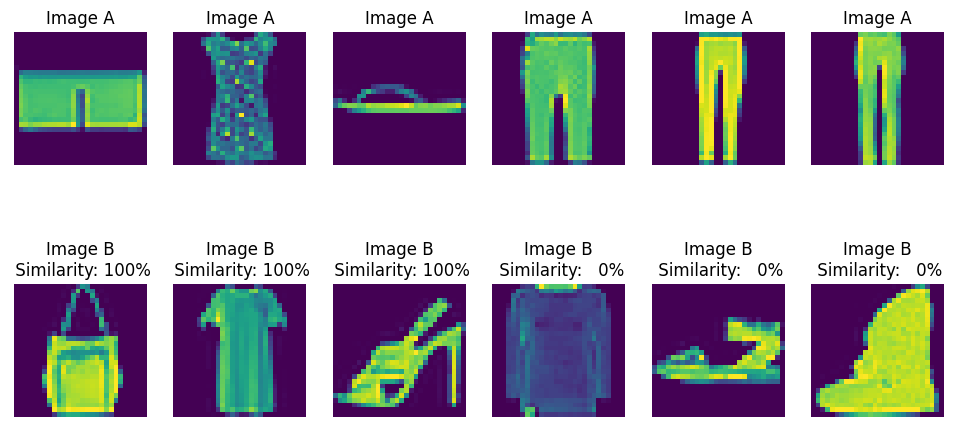

In [7]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [13]:
img_in = layers.Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
# перший Dense блок
x = layers.Conv2D(64, 3, padding="same")(img_in)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x1 = layers.concatenate([img_in, x], name = 'merge_features')

# другий Dense блок
x = layers.Conv2D(64, 3, padding="same")(x1)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x2 = layers.concatenate([x1, x])

# третій Dense блок
x = layers.Conv2D(64, 3, padding="same")(x2)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x3 = layers.concatenate([x2, x])

# четвертий Dense блок
x = layers.Conv2D(64, 3, padding="same")(x3)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x4 = layers.concatenate([x3, x])

# останній блок
x = layers.Conv2D(256, 3, padding="same")(x4)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.GlobalAveragePooling2D()(x)

# додавання повнозв'язного шару
outputs = layers.Dense(10, activation="softmax")(x)

# створення моделі
feature_model = keras.Model(inputs = [img_in], outputs = outputs, name = 'DenseNet')
feature_model.summary()

Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 FeatureNet_ImageInput (InputLa  [(None, 28, 28, 1)]  0          []                               
 yer)                                                                                             
                                                                                                  
 conv2d_13 (Conv2D)             (None, 28, 28, 64)   640         ['FeatureNet_ImageInput[0][0]']  
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 28, 28, 64)  256         ['conv2d_13[0][0]']              
 rmalization)                                                                                     
                                                                                           

                                                                                                  
 batch_normalization_17 (BatchN  (None, 28, 28, 256)  1024       ['conv2d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 28, 28, 256)  0           ['batch_normalization_17[0][0]'] 
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 256)         0           ['activation_17[0][0]']          
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_1 (Dense)                (None, 10)           2570        ['global_average_pooling2d_1[0][0
          

In [14]:
img_a_in = layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = layers.Dense(16, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)
combined_features = layers.Dense(4, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)
combined_features = layers.Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = keras.Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 DenseNet (Functional)          (None, 10)           860298      ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['DenseNet[0][0]',

In [15]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

1/1 [==============================] - 0s 410ms/step


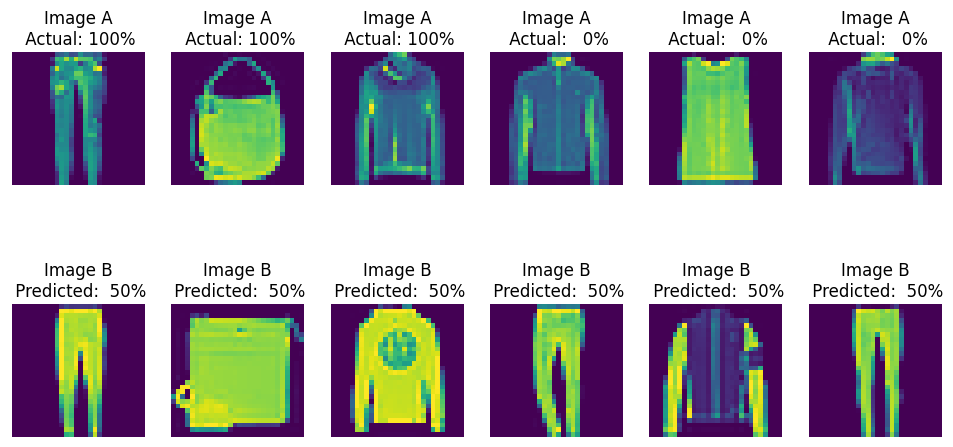

In [16]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [17]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups),
                                    steps_per_epoch = 500,
                                    validation_data=([valid_a, valid_b], valid_sim),
                                    epochs = 10,
                                    verbose = True)

Epoch 1/10


2023-04-04 16:34:22.457869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 1129s 2s/step - loss: 0.5362 - mae: 0.3865 - val_loss: 0.4957 - val_mae: 0.3379
Epoch 2/10
500/500 [==============================] - 1118s 2s/step - loss: 0.4195 - mae: 0.2853 - val_loss: 0.4311 - val_mae: 0.2811
Epoch 3/10
500/500 [==============================] - 1137s 2s/step - loss: 0.3877 - mae: 0.2567 - val_loss: 0.5960 - val_mae: 0.3252
Epoch 4/10
500/500 [==============================] - 1126s 2s/step - loss: 0.3696 - mae: 0.2398 - val_loss: 0.3549 - val_mae: 0.2374
Epoch 5/10
500/500 [==============================] - 1401s 3s/step - loss: 0.3581 - mae: 0.2322 - val_loss: 0.3569 - val_mae: 0.2161
Epoch 6/10
500/500 [==============================] - 1533s 3s/step - loss: 0.3407 - mae: 0.2193 - val_loss: 0.3501 - val_mae: 0.2095
Epoch 7/10
500/500 [==============================] - 1125s 2s/step - loss: 0.3459 - mae: 0.2202 - val_loss: 0.3105 - val_mae: 0.1993
Epoch 8/10
500/500 [==============================] - 1125s 2s/step - los

1/1 [==============================] - 0s 87ms/step


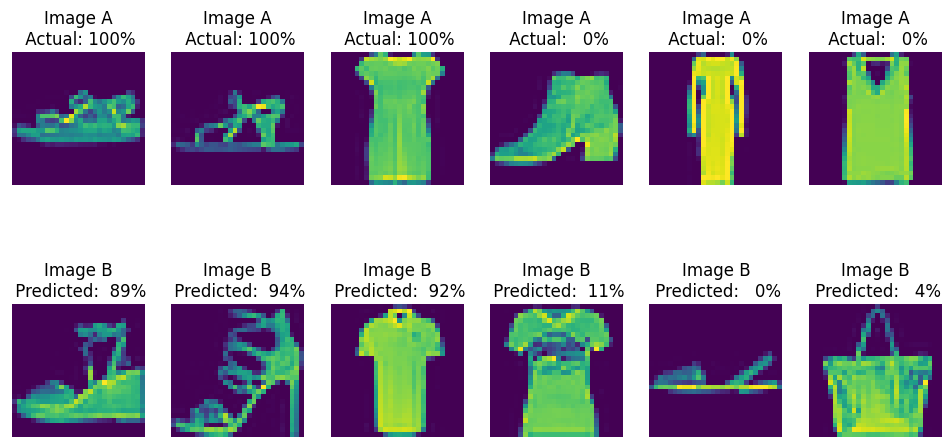

In [18]:
_ = show_model_output()

In [19]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose= True, batch_size = 128)

141/141 [==============================] - 278s 2s/step


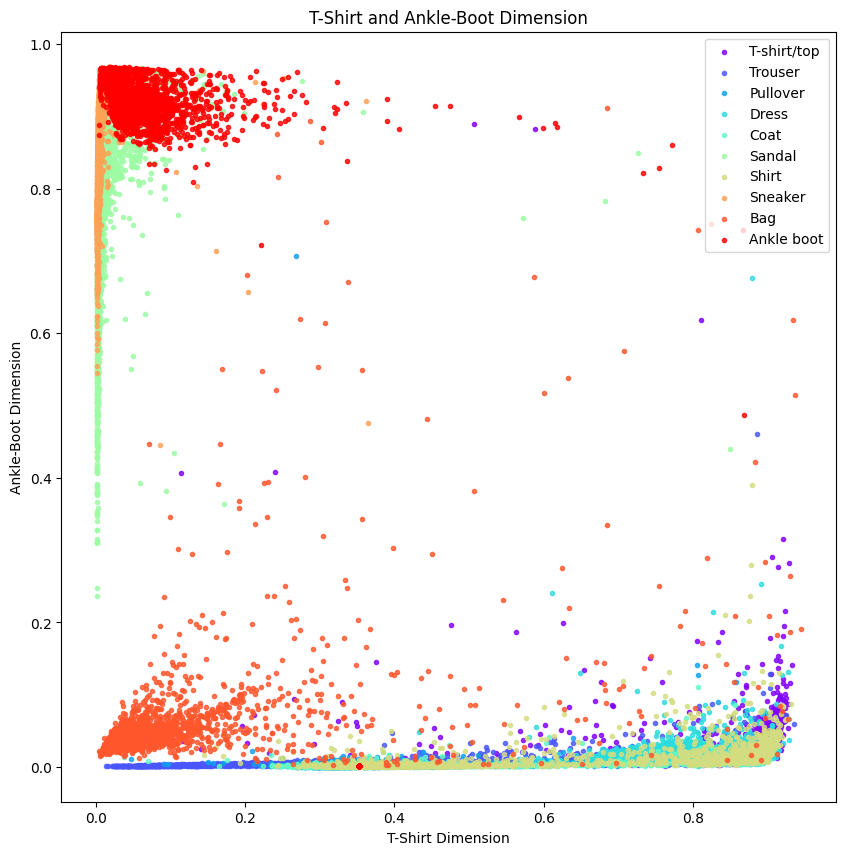

In [21]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [22]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

141/141 [==============================] - 140s 990ms/step


In [26]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=1000,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/home/iyark/notebook/jupyterenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.041s...
[t-SNE] Computed neighbors for 18000 samples in 0.570s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

/home/iyark/notebook/jupyterenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 84.4330292, gradient norm = 0.0030966 (50 iterations in 2.443s)
[t-SNE] Iteration 100: error = 79.2620468, gradient norm = 0.0017830 (50 iterations in 2.189s)
[t-SNE] Iteration 150: error = 77.2456207, gradient norm = 0.0011702 (50 iterations in 2.165s)
[t-SNE] Iteration 200: error = 76.1458588, gradient norm = 0.0008756 (50 iterations in 2.203s)
[t-SNE] Iteration 250: error = 75.4434738, gradient norm = 0.0006958 (50 iterations in 2.134s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.443474
[t-SNE] Iteration 300: error = 3.1010435, gradient norm = 0.0012190 (50 iterations in 2.158s)
[t-SNE] Iteration 350: error = 2.5581746, gradient norm = 0.0006578 (50 iterations in 2.201s)
[t-SNE] Iteration 400: error = 2.2217820, gradient norm = 0.0004182 (50 iterations in 2.103s)
[t-SNE] Iteration 450: error = 2.0064969, gradient norm = 0.0002949 (50 iterations in 2.132s)
[t-SNE] Iteration 500: error = 1.8574331, gradient norm = 0.0002221 (50 

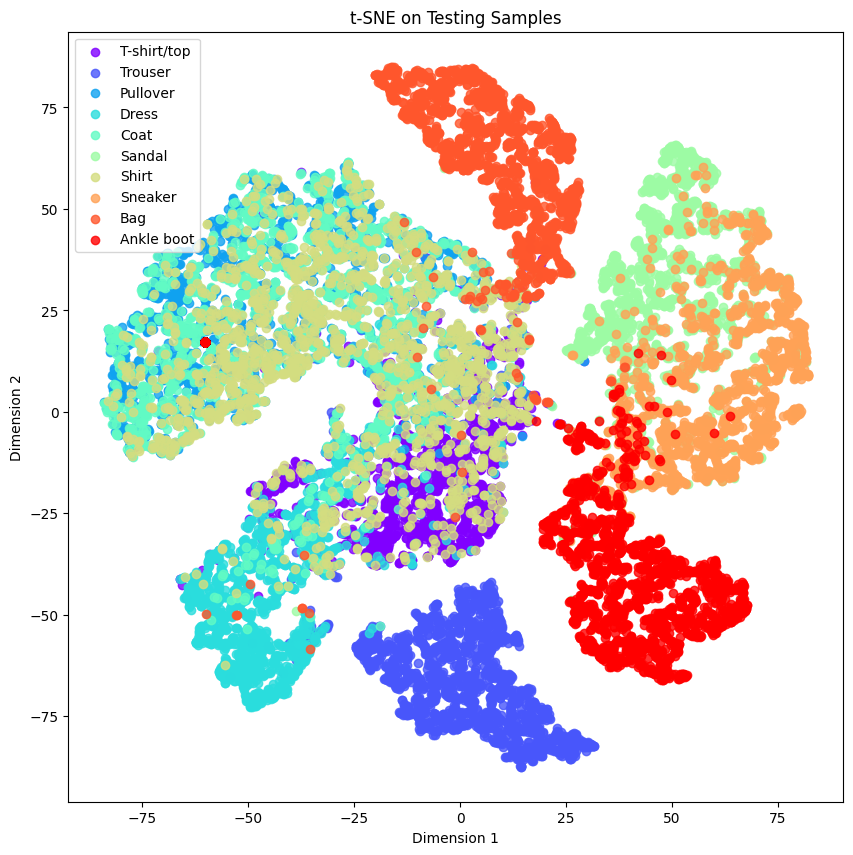

In [27]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
    tsne_features[np.where(y_test == c_group), 1],
    marker='o',
    color=c_color,
    linewidth=1,
    alpha=0.8,
    label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)